<a href="https://colab.research.google.com/github/leoooc/Vegetation-Dynamics-ViT/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 72.7 MB/s eta 0:00:00


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import rasterio
import numpy as np
import math
import time
import random

# Data Augmentation Function

def random_augmentation(patch, target):

    if random.random() > 0.5:
        patch = np.flip(patch, axis=2).copy()
        target = np.flip(target, axis=2).copy()
    if random.random() > 0.5:
        patch = np.flip(patch, axis=1).copy()
        target = np.flip(target, axis=1).copy()

    k = random.randint(0, 3)
    if k:
        patch = np.rot90(patch, k, axes=(1,2)).copy()
        target = np.rot90(target, k, axes=(1,2)).copy()
    return patch, target


# Dataset for 2-Channel (NDVI & VH) Merged Composite TIFF

class TiffDataset(Dataset):
    """
    Loads a merged composite GeoTIFF with 6 channels:
      [B2, B3, B4, B8, NDVI, VH]
    but slices out only channels 4 (NDVI) and 5 (VH).
    Extracts random patches, normalizes the data,
    applies data augmentation, and simulates missing NDVI data.
    """
    def __init__(self, tiff_path, patch_size=128, num_patches=1000):
        self.tiff_path = tiff_path
        self.patch_size = patch_size
        self.num_patches = num_patches


        with rasterio.open(tiff_path) as src:
            full_data = src.read()


        self.data = full_data[[4, 5], :, :]
        self.channels, self.height, self.width = self.data.shape


        self.mean = self.data.mean(axis=(1,2), keepdims=True)
        self.std = self.data.std(axis=(1,2), keepdims=True) + 1e-8

    def __len__(self):
        return self.num_patches

    def __getitem__(self, idx):

        max_x = self.width - self.patch_size
        max_y = self.height - self.patch_size
        x = np.random.randint(0, max_x)
        y = np.random.randint(0, max_y)


        patch = self.data[:, y:y+self.patch_size, x:x+self.patch_size].copy()
        target = patch.copy()


        patch = (patch - self.mean) / self.std
        target = (target - self.mean) / self.std


        start = self.patch_size // 4
        end = start + self.patch_size // 2
        patch[0, start:end, start:end] = 0


        patch, target = random_augmentation(patch, target)


        patch = torch.tensor(patch, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)
        return patch, target


class PatchEmbed(nn.Module):
    """
    Splits the input image into patches and projects them to an embedding space.
    """
    def __init__(self, in_channels=2, patch_size=16, embed_dim=512):
        super(PatchEmbed, self).__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x: (B, C, H, W)
        x = self.proj(x)
        B, C, H, W = x.shape

        x = x.flatten(2).transpose(1, 2)
        return x



class ViTInpainting(nn.Module):
    def __init__(self, in_channels=2, patch_size=16, embed_dim=512, num_layers=8,
                 num_heads=8, mlp_ratio=4.0, image_size=128):
        super(ViTInpainting, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        self.num_patches = (image_size // patch_size) * (image_size // patch_size)
        self.patch_embed = PatchEmbed(in_channels, patch_size, embed_dim)


        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches, embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)


        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            dropout=0.1,
            activation='gelu',
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)


        self.reconstruction_head = nn.Linear(embed_dim, patch_size * patch_size * in_channels)
        self.image_size = image_size

    def forward(self, x):

        B, C, H, W = x.shape

        x_patches = self.patch_embed(x)
        x_patches = x_patches + self.pos_embed


        x_encoded = self.transformer_encoder(x_patches)


        x_reconstructed = self.reconstruction_head(x_encoded)


        x_reconstructed = x_reconstructed.view(B, -1, C, self.patch_size, self.patch_size)
        grid_size = int(math.sqrt(self.num_patches))
        x_reconstructed = x_reconstructed.view(B, grid_size, grid_size, C, self.patch_size, self.patch_size)
        x_reconstructed = x_reconstructed.permute(0, 3, 1, 4, 2, 5).contiguous()
        x_reconstructed = x_reconstructed.view(B, C, H, W)
        return x_reconstructed


def train_model(model, dataloader, num_epochs=20, learning_rate=1e-4, device='cuda'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    scaler = torch.cuda.amp.GradScaler() if device == 'cuda' else None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=(scaler is not None)):
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            if i % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], Loss: {loss.item():.4f}")
        epoch_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {epoch_loss:.4f}")

    print("Training complete.")


if __name__ == '__main__':
    # Hyperparameters
    in_channels = 2       # NDVI and VH
    image_size = 128
    patch_size = 16
    embed_dim = 512
    num_layers = 8
    num_heads = 8
    num_epochs = 20
    batch_size = 8

    # Path to your 6-channel GeoTIFF (NDVI and VH at channels 4 and 5)
    tiff_path = '/content/drive/MyDrive/EarthEngineExports/Merged_Composite.tif'


    dataset = TiffDataset(tiff_path, patch_size=image_size, num_patches=1000)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = ViTInpainting(
        in_channels=in_channels,
        patch_size=patch_size,
        embed_dim=embed_dim,
        num_layers=num_layers,
        num_heads=num_heads,
        image_size=image_size
    )


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    start_time = time.time()
    train_model(model, dataloader, num_epochs=num_epochs, device=device)
    print("Total training time: {:.2f} seconds".format(time.time() - start_time))


<ipython-input-8-ffaf98cc7442>:178: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None)):


Epoch [1/20], Step [0/125], Loss: 1.4599
Epoch [1/20], Step [10/125], Loss: 0.9644
Epoch [1/20], Step [20/125], Loss: 0.6765
Epoch [1/20], Step [30/125], Loss: 0.6371
Epoch [1/20], Step [40/125], Loss: 0.6196
Epoch [1/20], Step [50/125], Loss: 0.4942
Epoch [1/20], Step [60/125], Loss: 0.6202
Epoch [1/20], Step [70/125], Loss: 0.5990
Epoch [1/20], Step [80/125], Loss: 0.4609
Epoch [1/20], Step [90/125], Loss: 0.4405
Epoch [1/20], Step [100/125], Loss: 0.4548
Epoch [1/20], Step [110/125], Loss: 0.4661
Epoch [1/20], Step [120/125], Loss: 0.3684
Epoch [1/20] Average Loss: 0.5738
Epoch [2/20], Step [0/125], Loss: 0.3498
Epoch [2/20], Step [10/125], Loss: 0.3067
Epoch [2/20], Step [20/125], Loss: 0.2802
Epoch [2/20], Step [30/125], Loss: 0.3008
Epoch [2/20], Step [40/125], Loss: 0.3721
Epoch [2/20], Step [50/125], Loss: 0.3065
Epoch [2/20], Step [60/125], Loss: 0.2445
Epoch [2/20], Step [70/125], Loss: 0.3795
Epoch [2/20], Step [80/125], Loss: 0.2122
Epoch [2/20], Step [90/125], Loss: 0.3136

KeyboardInterrupt: 

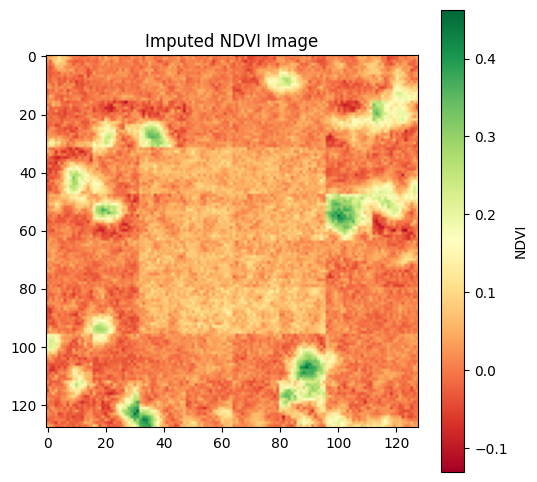

In [9]:
import matplotlib.pyplot as plt


model.eval()


patch, target = dataset[0]


patch = patch.unsqueeze(0).to(device)


with torch.no_grad():
    output = model(patch)

imputed_output = output[0, 0].cpu().numpy()


mean_ndvi = dataset.mean[0, 0, 0]
std_ndvi = dataset.std[0, 0, 0]
imputed_ndvi = imputed_output * std_ndvi + mean_ndvi


plt.figure(figsize=(6,6))
plt.imshow(imputed_ndvi, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.title('Imputed NDVI Image')
plt.show()
